This notebook shows how to read from a "zarr" dataset, which has been "chunked" (broken into a little bits) in a way that makes grabbing a time series from a single point very quickly. 

The essence is that while the original data was many raster files, each file representing imagery from a single timestamp, the "zarr" dataset is stored in time series, so there is a single file for each pixel and all the values in time belonging to that pixel (actually, the files are 3x3 pixels).

In [11]:
import xarray as xr
import glob
import os
import datetime as dt
import matplotlib.pyplot as plt
from dask.distributed import Client, LocalCluster


### Start a Dask Cluster 

In [12]:
# Create a Dask cluster so we can watch the dask dashboard
workers = 12
ip_addres = 'http://j-lundquist-3.ce.washington.edu'
port=':8787'
threads = 2
cluster = LocalCluster(n_workers=workers, threads_per_worker=threads, dashboard_address=port)
client = Client(cluster)

/home/elilouis/mambaforge/envs/gtsa/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46638 instead
  warnings.warn(


### We have to get the datetimes from the file names because, unfortunately, zarr has a bug that does not allow it to save `datetime64[ns]` objects correctly (precision is lost)

In [ ]:
image_folder = '/storage/GOES/orthorectified/Fog2022_withtime/'
files = glob.glob(os.path.join(image_folder, "*_o.nc"))
datetimes = [
    dt.datetime.strptime(
        f.split('/')[-1].split('_')[3][1:-3],
        "%Y%j%H%M%S"
    ) for f in files
]
datetimes = sorted(datetimes)

### Open the zarr dataset and replace the time index 

In [4]:
zarr_path = '/storage/GOES/orthorectified/Fog2022_withtime.zarr'
ds = xr.open_dataset(
    zarr_path,
    # chunks={'time': 40785, 'latitude': 3, 'longitude': 3},
    chunks={'time': 40785, 'latitude': 10, 'longitude': 10},
    engine='zarr'
)
ds['time'] = datetimes

/home/elilouis/mambaforge/envs/gtsa/lib/python3.11/site-packages/xarray/core/dataset.py:265: UserWarning: The specified chunks separate the stored chunks along dimension "latitude" starting at index 10. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/home/elilouis/mambaforge/envs/gtsa/lib/python3.11/site-packages/xarray/core/dataset.py:265: UserWarning: The specified chunks separate the stored chunks along dimension "longitude" starting at index 10. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


### Let's look at the time series at a single point, for 6 days

In [5]:
series = ds['HT'].sel(latitude = 48.509018, longitude = -123.035467, method='nearest')

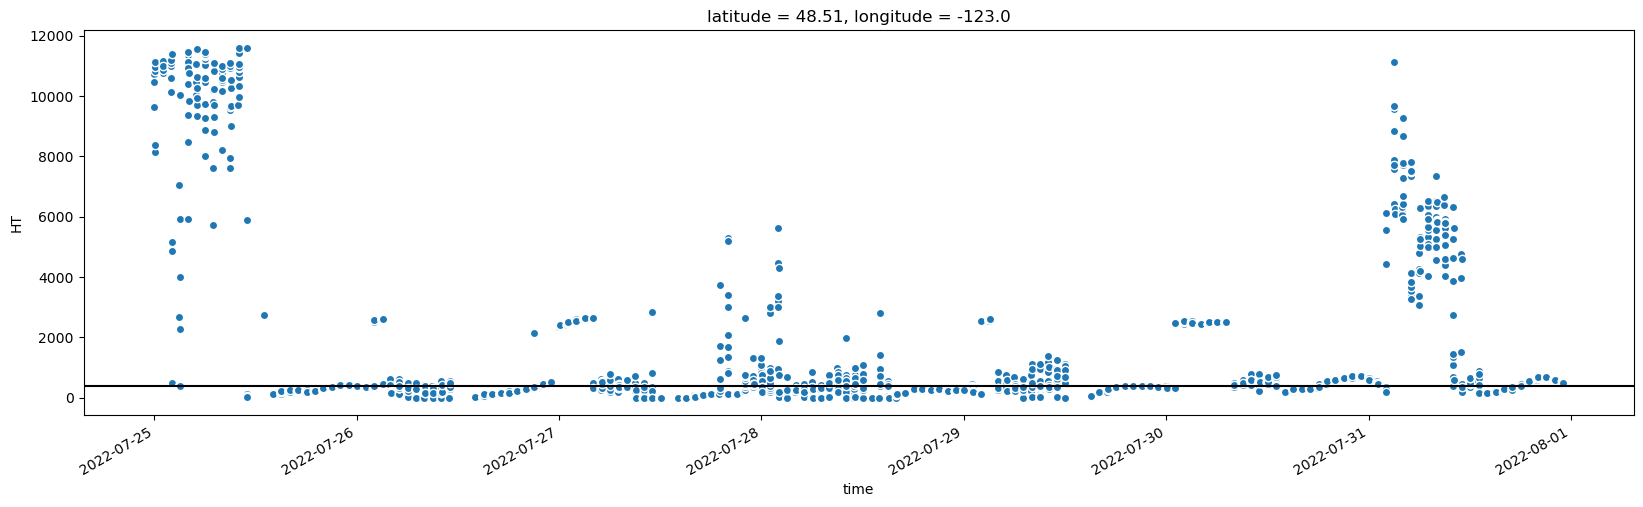

In [28]:
plt.figure(figsize = (20,5))
series.sel(time = slice('July 25, 2022', 'July 31, 2022')).plot.scatter('time')
plt.axhline(400, color='k')

In [7]:
pt1 = [48.50891,        -123.03491]
pt2 = [48.55745,        -123.0824]
pt3 = [48.52329,        -123.1371]
pt4 = [40.55423,        -122.36151]
pt5 = [48.46446,        -122.96222]
pt6 = [48.53304291, 	-123.0882645]
pt7 = [48.61820602, 	-123.1203384]
pt8 = [48.56717682, 	-123.1648407]
pt9 = [48.48910141, 	-123.0627441]
pt10 = [48.48910141, 	-123.0627441]
pt11 = [48.490756, 	    -123.067895]
pt12 = [48.57880161, 	-123.1731671]

### Calculate a fog frequency map

In [8]:
ds['FLCC'] = (ds['HT'] < 400).astype(int)

### We call load to get this in memory right away - then plotting doesn't take a long time.

In [16]:
FLCC_freq = (
    ds['FLCC'].sum(dim='time') / ds['time'].size
).load()

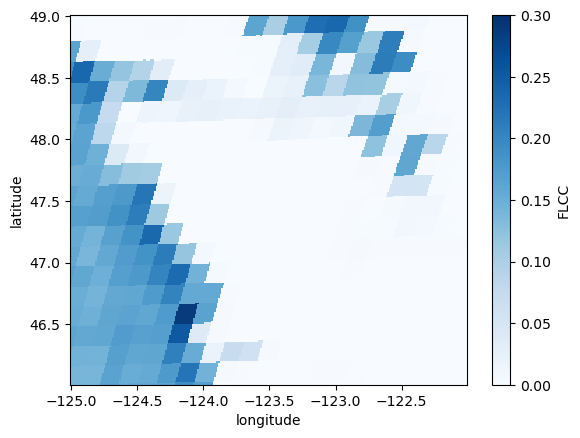

In [23]:
FLCC_freq.plot(cmap = 'Blues', vmin=0.0, vmax=0.3)